In [3]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

# 1.Obtención del mapa de Open Street Maps.

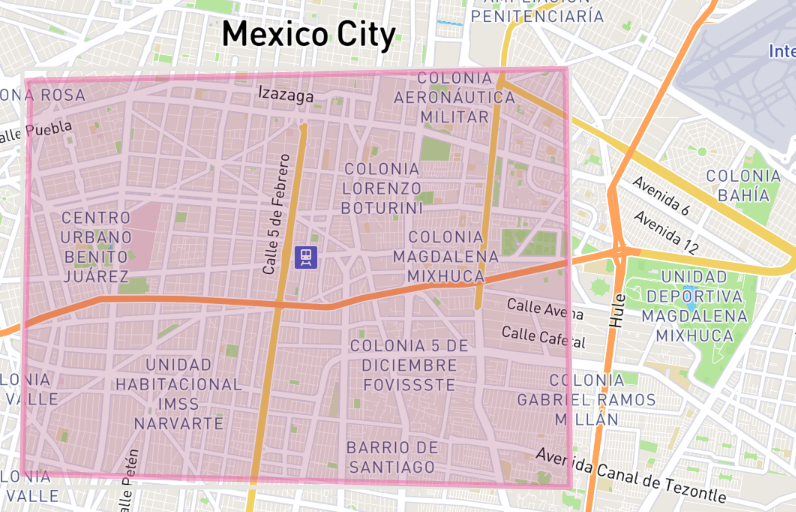

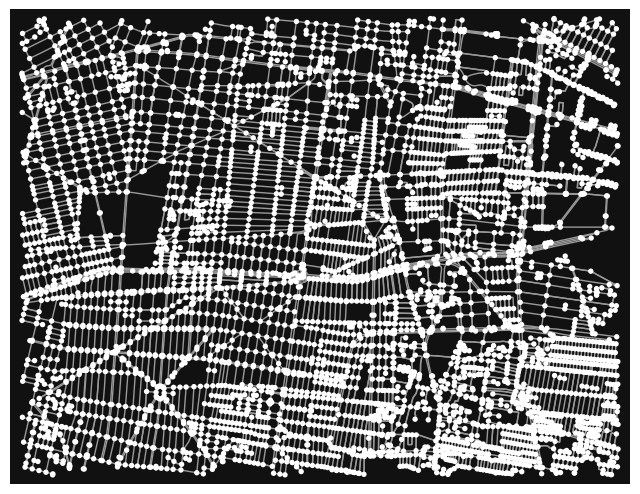

In [4]:
# define un bounding box en la CDMX
west, south, east, north = -99.165802,19.383783,-99.103231,19.428955
# Crear red nodos-aristas del bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive")
fig, ax = ox.plot_graph(G)

In [5]:
print(len(G.nodes))
print(len(G.edges))
print(G)

5376
11191
MultiDiGraph with 5376 nodes and 11191 edges


# 2. Creación del archivo net.xml usado en SUMO.

In [6]:
import os
import sys
import subprocess
#Para poder utilizar las funciones propias de SUMO desde python
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))

def crear_mapa_xml(G, file_name):
    #configuracion en osmnx para obtener el archivo xml
    fileName = file_name
    utn = ox.settings.useful_tags_node
    oxna = ox.settings.osm_xml_node_attrs
    oxnt = ox.settings.osm_xml_node_tags
    utw = ox.settings.useful_tags_way
    oxwa = ox.settings.osm_xml_way_attrs
    oxwt = ox.settings.osm_xml_way_tags
    utn = list(set(utn + oxna + oxnt))
    utw = list(set(utw + oxwa + oxwt))
    ox.settings.all_oneway = True
    ox.settings.useful_tags_node = utn
    ox.settings.useful_tags_way = utw
    ox.settings.all_oneway = True
    ox.save_graph_xml(G, filepath = fileName)

def crear_mapa_SUMO(fileName):
    #funcion de SUMO
    import osmBuild
    
    #opciones de conversión
    netconvert_options = " --geometry.remove --ramps.guess --junctions.join --tls.guess-signals"+ " --tls.discard-simple --tls.join --tls.default-type actuated"
    args= ["--osm-file", fileName, "--vehicle-classes=road", 
           "--netconvert-options", netconvert_options]
    
    #funcion para crear mapa SUMO
    osmBuild.build(args)

# 3. Diccionario de aristas y nodos a partir del mapa SUMO.

In [7]:
def crear_dict_sumo_mapa(file_name):

    # Cargar el archivo XML
    tree = ET.parse(file_name)
    root = tree.getroot()

    # Crear un diccionario para almacenar los edges por su combinación de 'from' y 'to'
    edges_dict = {}
    edges_dict_special = {}
    edges_dict_guion = {}

    # Iterar sobre los elementos <edge>

    clusters = set()
    #auxiliares para construir el diccionario guion
    auxG = -1
    auxG2 = 0
    auxG3 = 0
    listG = []
    edgeGfrom = None
    edgeGto = None

    for edge in root.iter('edge'):
        special_nodes = []
        # Obtener los valores de los atributos 'from', 'to' e 'id'
        edge_from = edge.get('from')
        edge_id = edge.get('id')
        edge_to = edge.get('to')

        if edge_from:
        ####Para checar guiones -AddedOffRampNode#######
            e_f_s = edge_from.split("-")
            if len(e_f_s) > 1 and auxG==-1:
                edge_split = edge_to.split("_")
                e_t_s = edge_to.split("-")
                if len(edge_split) > 2 or len(e_t_s) == 1:
                    auxG = 1
                    auxG3 = 1
                else:
                    auxG = 2


        if edge_to:
        ####Para checar clusters##########
            edge_split = edge_to.split("_")
            if len(edge_split) > 2:
                for arista in edge_split:
                    clusters.add(arista)

        ####Para checar guiones -AddedOffRampNode#######
            e_t_s = edge_to.split("-")
            if len(e_t_s) > 1 and auxG==-1:
                auxG = 1

        auxE = 0
        for param in edge.iter('param'):
            if param.get('key') == "origId":
                value_origId =  param.get('value').split(" ")
                if len(value_origId) > 1:
                    auxE = auxE + 1

            elif param.get('key') == "origFrom":
                edge_from = param.get('value')
                if auxE:
                    special_nodes.append(param.get('value'))

            elif param.get('key') == "origTo":
                edge_to = param.get('value')
                if auxE:
                    special_nodes.append(param.get('value'))

        if auxE:
            special_nodes.append(edge.get('from'))
            special_nodes.append(edge.get('to'))
            counter = 0
            for node in special_nodes:
                if node in edges_dict_special:
                    edges_dict_special[node][1] += 1
                else:
                    edges_dict_special[node] = [edge_id, counter]

        ########Construir diccionario guiones#########
        if auxG != -1:
            if auxG == 2:
                listG.append(edge_id)
                auxG -= 1
                auxG2 = 1

            elif auxG == 1:
                listG.append(edge_id)
                auxG -= 1
                for param in edge.iter('param'):
                    if param.get('key') == "origFrom":
                        edgeGfrom = param.get('value')
                    elif param.get('key') == "origTo":
                        edgeGto = param.get('value')
                if not edgeGfrom:
                    efs = edge_from.split("-")
                    if len(efs) > 1:
                        edgeGto = edge_to

                if not edgeGto:
                    ets = edge_to.split("-")
                    if len(ets) > 1:
                        edgeGfrom = edge_from
            else:
                if auxG2 or auxG3:
                    listG.insert(0,edge_id)
                else:
                    listG.append(edge_id)

                if not edgeGto:
                    edgeGto = edge_to
                if not edgeGfrom:
                    edgeGfrom = edge_from

                edges_dict_guion[(edgeGfrom, edgeGto)] = listG

                auxG = -1
                auxG2 = 0
                auxG3 = 0
                listG = []
                edgeGfrom = None
                edgeGto = None

        ##############################################
        edge_key = (edge_from, edge_to)
        edges_dict[edge_key] = edge_id
        
    return edges_dict, edges_dict_special, edges_dict_guion, clusters

# 4. Creación de rutas aleatorias.

In [8]:
#longitud, latitud
destinos = [["metro Iztacalco",(-99.1122268021, 19.389042825141992)],
           ["metro Coyuya",(-99.11344828989398, 19.398097930013037)],
           ["metro Etiopia",(-99.15606229345083, 19.39593952533453)],
           ["metro Xola", (-99.13780912121953, 19.39525177855882)],
           ["metro Viaducto", (-99.13690468723141, 19.400976580148026)],
           ["metro La Viga", (-99.12626179026907, 19.406719772851407)],
           ["metro Lazaro Cardenas",(-99.14463368224291, 19.407269278889917)],
           ["metro Cuauhtemoc", (-99.15458599433383, 19.42590770541133)],
           ["metro Merced", (-99.12521347728297, 19.42553816384818)],
           ["metro Pino Suarez", (-99.13293005335198, 19.424465379511155)],
           ["metro San Antonio Abad", (-99.13459337870798, 19.41580055422141)],
           ]

def creacion_rutas(G, Nrutas, destinos1):
    rutas = []
    
    np.random.seed(123)

    # Re-proyectar el grafo a un CRS proyectado
    G2 = ox.projection.project_graph(G)
    G3 = ox.utils_graph.get_undirected(G2)
    
    # Generar 100 puntos aleatorios en la misma área que el grafo
    points = ox.utils_geo.sample_points(G3, Nrutas)
    
    # Convertir a coordenadas
    points_to_sg = ox.projection.project_gdf(points, to_latlong=True)
    points_frame = points_to_sg.to_frame()
    points_frame = points_frame.reset_index()
    points_coordinates = [(point.x, point.y) for point in points_frame[0]]
    
    #Obtener rutas origen-destino
    for point in points_coordinates:
        ruta = {}
        destino_aleatorio = np.random.choice(len(destinos1))
        coordenadas_destino = destinos1[destino_aleatorio][1]

        orig = ox.distance.nearest_nodes(G, X=point[0], Y=point[1])
        dest = ox.distance.nearest_nodes(G, X=coordenadas_destino[0], Y=coordenadas_destino[1])
        nodes_route = ox.shortest_path(G, orig, dest, weight='length')

        orig_dest = (orig, dest)
        dest_name = destinos1[destino_aleatorio][0]
        ruta = {"orig_dest":orig_dest, "dest_name":dest_name, "nodes_route":nodes_route}
        rutas.append(ruta)
    
    return rutas

# 5. Creación de rutas SUMO.

In [23]:
def creacion_rutas_SUMO(routes, edges_dict, edges_dict_special, edges_dict_guion, clusters):
    idx = 0
    route_none = []
    aux2 = 0
    rutas = routes.copy()
    '''
    1-both nodes in cluster- se encuentran los dos nodos en el mismo cluster de SUMO, por lo que no hay una arista en SUMO y
    se puede ignorar para SUMO.

    2-in-special-dict - por el momento, pienso que si se encuentra en este diccionario, se puede ignorar, no todos pero puede 
    que algunos si.

    3-in-guion-dict - hay que cambiarlo porque existen dos formas, que tengan dos edges o tres edges. por el momento solo funciona
    con dos.

    '''
    for ruta in rutas:
        if ruta['nodes_route']:
            ruta_edges = []
            sumo_route = []
            edges_not_dictionary = []
            aux3 = 0
            for node, i in zip(ruta['nodes_route'], range(len(ruta['nodes_route']))):
                if node != ruta['nodes_route'][-1]:
                    origen = str(node)
                    destino = str(ruta['nodes_route'][i+1])
                    r_edge = (origen, destino)

                    # r-edge: 0-ok, 1-both nodes in a cluster, 2-in-special-dict, 3-in-dict-guion, 4-error

                    ###############################################
                    if r_edge in edges_dict_guion:
                        for arista in edges_dict_guion[r_edge]:
                            sumo_route.append(arista)
                        ruta_edges.append([r_edge, 3])
                        edges_not_dictionary.append([r_edge, 3])
                    ################################################

                    else:
                        #sumo_route viene del diccionario sin cambios, todo ok
                        if r_edge in edges_dict:
                            sumo_route.append(edges_dict[r_edge])
                            ruta_edges.append([r_edge, 0])

                        elif r_edge[0] in clusters and r_edge[1] in clusters:
                            ruta_edges.append([r_edge, 1])
                            edges_not_dictionary.append([r_edge, 1])
                        else:
                            ##################################################################
                            #checa si el nodo 1 o nodo 2 se encuentran en el diccionario especial,
                            #el primer if y elif. si no, hay q checar en el diccionario de guion.
                            if r_edge[0] in edges_dict_special:
                                if edges_dict_special[r_edge[0]][1] ==0:
                                    if len(sumo_route):
                                        if sumo_route[-1] != edges_dict_special[r_edge[0]][0]:
                                            sumo_route.append(edges_dict_special[r_edge[0]][0])  
                                            ruta_edges.append([r_edge, 2])
                                            edges_not_dictionary.append([r_edge, 2])
                                    else:
                                        sumo_route.append(edges_dict_special[r_edge[0]][0])  
                                        ruta_edges.append([r_edge, 2])
                                        edges_not_dictionary.append([r_edge, 2])                               
                            elif r_edge[1] in edges_dict_special:
                                if edges_dict_special[r_edge[1]][1] ==0:
                                    if len(sumo_route):
                                        if sumo_route[-1] != edges_dict_special[r_edge[1]][0]:
                                            sumo_route.append(edges_dict_special[r_edge[1]][0])  
                                            ruta_edges.append([r_edge, 2])
                                            edges_not_dictionary.append([r_edge, 2])
                                    else:
                                        sumo_route.append(edges_dict_special[r_edge[1]][0])  
                                        ruta_edges.append([r_edge, 2])
                                        edges_not_dictionary.append([r_edge, 2])
                            ########################################################################
                            else:
                                ruta_edges.append([r_edge, 4])
                                edges_not_dictionary.append([r_edge, 4])
                                if aux3 == 0:
                                    aux2 = aux2+1
                                    aux3 = aux3 + 1

            ruta['ruta_edges'] = ruta_edges
            ruta['sumo_route'] = sumo_route
            ruta['edges_not_dictionary'] =edges_not_dictionary

        else:
            route_none.append(idx)
        idx = idx + 1

# 6. Limpieza de rutas SUMO.

In [10]:
# r-edge: 0-ok, 1-both nodes in a cluster, 2-in-special-dict, 3-in-dict-guion, 4-error
def split_routes(rutas):
    #0: 0, 1 y 3
    #2: 2
    #4: 4
    #100: no hay nodes_route, no existe un camino entre nodos
    #101: un unico nodo, no existe una ruta sumo
    sumo_routes = {0:[], 2:[], 4:[], 100:[], 101:[]}
    for ruta in rutas:
        aux2 = 0
        aux4 = 0
        if 'edges_not_dictionary' in ruta:
            for notDic in ruta['edges_not_dictionary']:
                if notDic[1] == 2:
                    aux2 = 1
                elif notDic[1] == 4:
                    aux4 = 1
        if aux4:
            sumo_routes[4].append(ruta) 
        elif aux2:
            sumo_routes[2].append(ruta)
        else:
            if ruta['nodes_route']:
                if ruta['sumo_route']:
                    sumo_routes[0].append(ruta)
                else:
                    sumo_routes[101].append(ruta)
            else:
                sumo_routes[100].append(ruta)
    return sumo_routes

# 7. Creación del archivo rutas rou.xml para SUMO.

In [11]:
def create_xml_routes(route_data, file_name):
    # create the root element
    root = ET.Element('routes', {'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance', 'xsi:noNamespaceSchemaLocation': 'http://sumo.dlr.de/xsd/routes_file.xsd'})

    # create child elements with attributes
    for i, data in enumerate(route_data):
        vehicle = ET.SubElement(root, 'vehicle', {'id': str(i), 'depart': '0.00'})
        route = ET.SubElement(vehicle, 'route', {'edges': ' '.join(map(str, data['sumo_route']))})

    # create the XML tree and write to file
    tree = ET.ElementTree(root)
    tree.write(file_name, xml_declaration=True)

# 8. Simulación de rutas en SUMO.

In [15]:
def run_sumo_simulation(file_config_name, report_name, emiss_report_name):
    sumo_binary = os.path.join(os.environ['SUMO_HOME'], 'bin', 'sumo')
    #output = "--full-output"
    output1 = "--tripinfo-output"
    output2 = "--emission-output"
    # Ejecutar la simulación
    subprocess.call([sumo_binary, "-c", file_config_name, output1 , report_name, output2, emiss_report_name])

# 9. Creación de rutas compartidas.

In [24]:
def create_dest_orig(routes):
    orig_dest = {}
    for route in routes:
        orig = route['orig_dest'][0]
        dest = route['orig_dest'][1]
        if not dest in orig_dest:
            orig_dest[dest] = []
        orig_dest[dest].append(orig)
    return orig_dest

def ideal_group_nodes(dest_orig):
    for key in dest_orig:
        distances[key]={}
        nodes = dest_orig[key]
        nodes_group = []
        nodes_car = []
        for i in nodes:
            dist=np.array([])
            aux_nodes = []
            if i not in nodes_group:
                nodes_car.append(i)
                nodes_group.append(i)
                for j in nodes:
                    if j not in nodes_group:
                        dist = np.append(dist, ox.distance.euclidean_dist_vec(G.nodes[i]['y'], G.nodes[i]['x'], G.nodes[j]['y'], G.nodes[j]['x']))
                        aux_nodes.append(j)
                sorted_indices = dist.argsort()
                smallest_indices = sorted_indices[:4]
                values_indices = []
                for z in smallest_indices:
                    values_indices.append(aux_nodes[z])
                    nodes_group.append(aux_nodes[z])
                distances[key][i] = values_indices
        distances[key]['nodes_car'] = nodes_car       
    return distances

def new_routes(nodes_group, rutas):
    route_keys = []
    nuevas_rutas = []
    for dest in nodes_group:
        for orig in nodes_group[dest]['nodes_car']:
            route_keys.append((orig,dest))
    
    for ruta in rutas:
        if ruta['orig_dest'] in route_keys:
            nuevas_rutas.append(ruta)
    return nuevas_rutas

# Paso 10 y 11 se mandan a llamar las funciones create_xml_routes y run_sumo_simulation pero usando la nueva informacion del paso anterior.

# 12. Graficas de simulación (emisiones).

In [17]:
def plot_emiss(contaminante, plot_name, emissions_report, vehId):
    import visualization.plotXMLAttributes as pltXML
    #help(pltXML)
    args = ["-x","time", "-y", contaminante, "-s", "-o", plot_name, emissions_report, "--filter-ids", vehId, "--legend"]
    options = pltXML.getOptions(args)
    pltXML.main(options)